In [67]:
%reload_ext autoreload
%autoreload 2
import pandas
import numpy
import matplotlib

from lib.sampling import *
from lib.geometry import *


# Global parameters

In [68]:
# How many radar scans to simulate
n_scans = 100
n_points_per_scan = 15

# Ground-truth velocity distribution
v_sampling_config = {
    "vx": {"distribution": "uniform", "params": {}, "bounds": (-2, 2)},
    "vy": {"distribution": "uniform", "params": {}, "bounds": (-0.5, 0.5)},
    "vz": {"distribution": "uniform", "params": {}, "bounds": (-0.5, 0.5)},
}

# Sampling (continuous) Radar datapoints

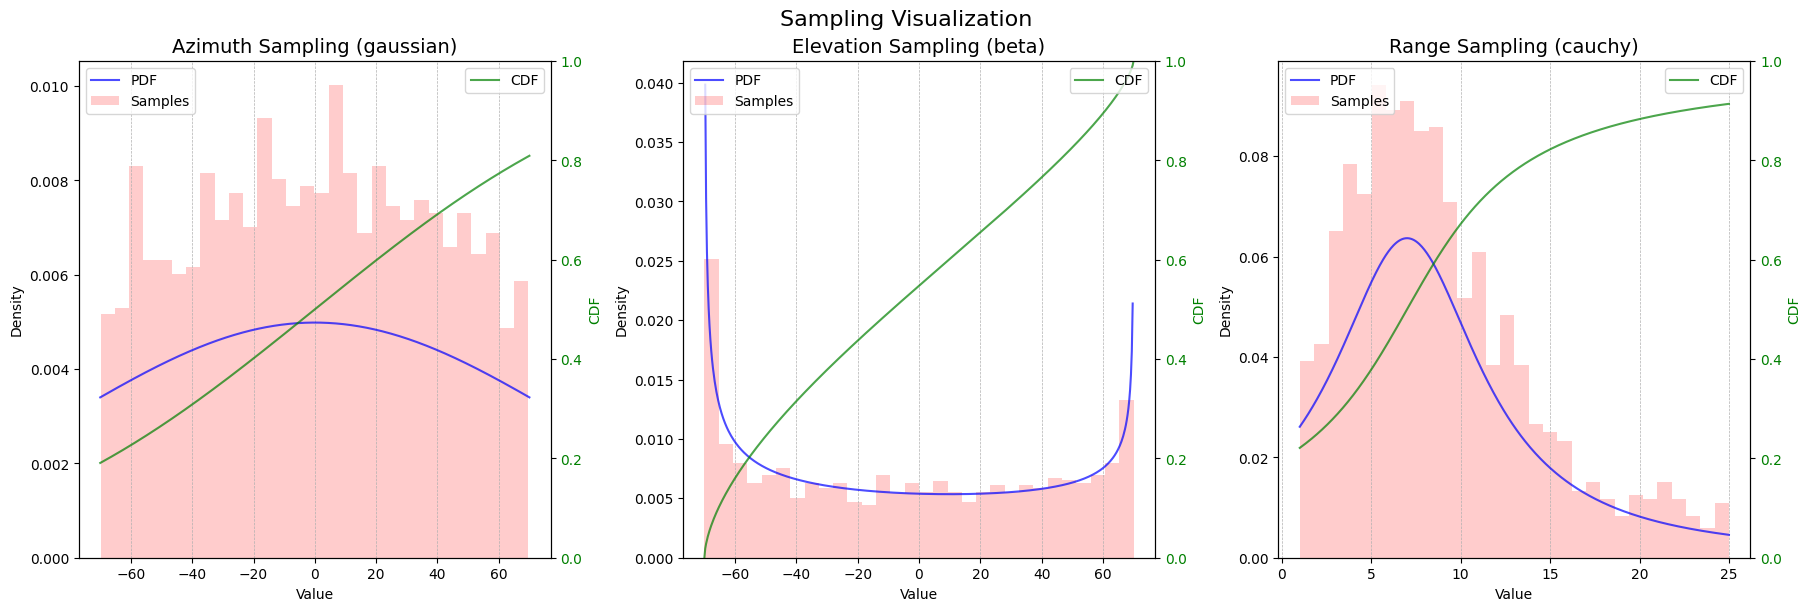

In [97]:
# Example Usage
radar_sampling_config = {
    "azimuth": {"distribution": "gaussian", "params": {"mean": 0, "std_dev": 80}, "bounds": (-70, 70)},
    "elevation": {"distribution": "beta", "params": {"alpha": 0.6, "beta": 0.7}, "bounds": (-70, 70)},
    "range": {"distribution": "cauchy", "params": {"loc": 7, "scale": 5}, "bounds": (1, 25)},
}

# Initialize the sampler
radar_sampler = MultiDimensionalSampler(radar_sampling_config)

radar_sampler.sample(num_samples=n_scans*n_points_per_scan) # np.array with columns [azimuth, elevation, range]

# Generate and visualize samples
radar_sampler.visualize_sampling()

radar_samples = radar_sampler.get_samples()

## Sample ground truth velocities (randomly)

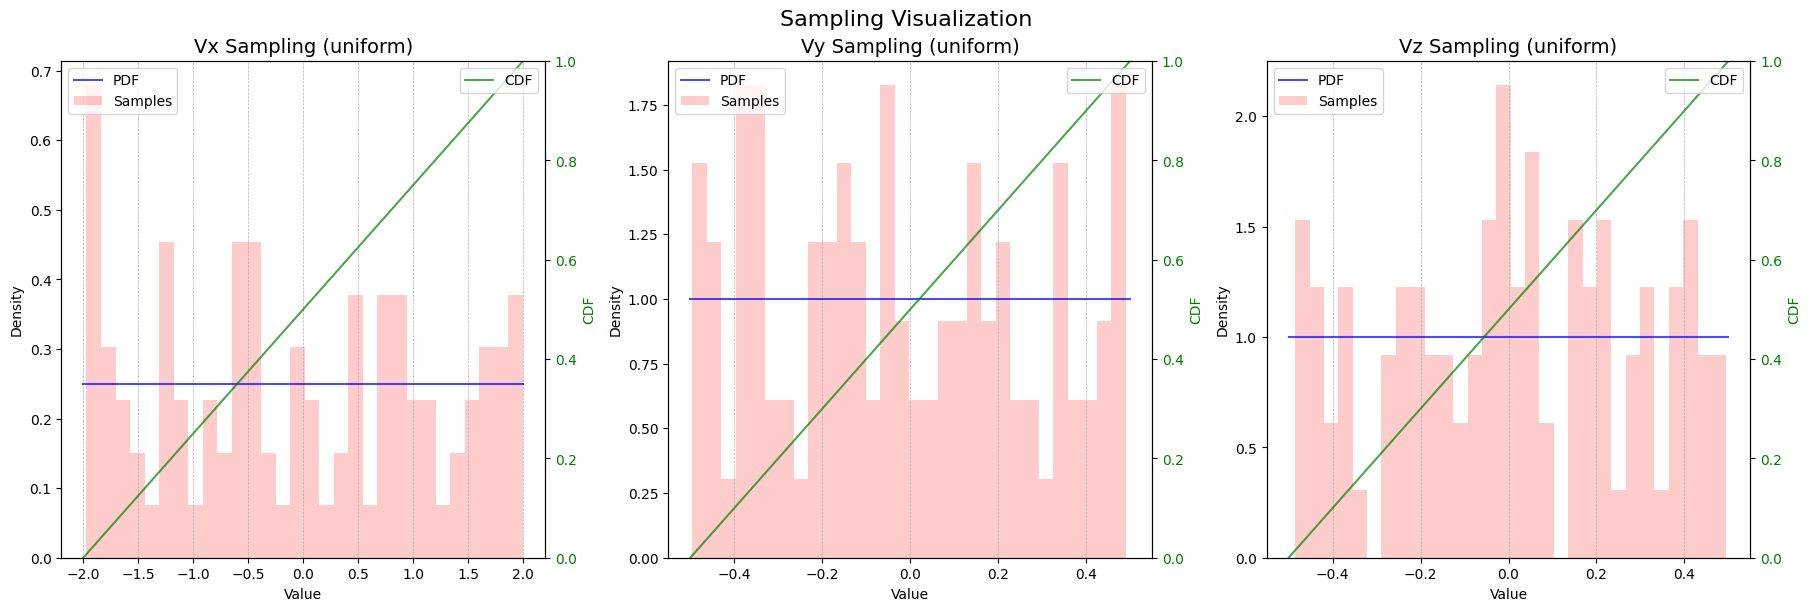

In [98]:
v_sampler = MultiDimensionalSampler(v_sampling_config)
v_sampler.sample(num_samples=n_scans)

v_sampler.visualize_sampling()

velocity_gt_samples = v_sampler.get_samples()

## Calculate doppler from ground-truth velocities
All radar data will be in `radar_array`.
Columns in order are:
- azimuth [°]
- elevation [°]
- range [m]
- doppler [m/s]
- vx_gt [m/s]
- vy_gt [m/s]
- vz_gt [m/s]
- scan_counter
Where gt stands for ground-truth.
`scan_counter`is simply a counter which indicates all rows that belong to a single radar scan.

In [115]:
# Empty array to store: [azimuth, elevation, range, doppler, vx_gt, vy_gt, vz_gt, scan_counter]
radar_array = np.empty((0, 8))

# With radar samples and velocity samples, add measured doppler shift to each radar datapoint
for scan_counter in range(n_scans):

    # Calculate projected velocity onto radar line of sight for n_points_per_scan
    radar_points_from_single_scan = from_gt_to_doppler(velocity_gt_samples[scan_counter,:], 
                                                       radar_samples[scan_counter*n_points_per_scan:(scan_counter+1)*n_points_per_scan,:])
    
    # Append the ground truth velocity to the radar points
    radar_points = np.hstack((radar_points_from_single_scan,
                             np.tile(velocity_gt_samples[scan_counter,:], (n_points_per_scan, 1)),
                             np.tile(scan_counter, (n_points_per_scan, 1))))

    # Append the radar points to the radar array
    radar_array = np.vstack((radar_array, radar_points))

# Discretization
The following section handles discretizing the *(approx. continuous)* data from the `radar_array`.
Goal is to see, how many radar-points are required under certain discretization to maintain a precise estimate on the ground truth velocity.

Intuition behind it;
- if one radar scan detects many radar points, then despite each radar point being discretized, the fact that I have many geometric constraints that my ego-velocity would be given extremely precisely.

In [132]:
angles = np.linspace(-70, 70, 15)

# Make a cross product of all possible azimuth and elevation combinations using array angles
azimuths, elevations = np.meshgrid(angles, angles)
# Count the number of combinations
n_points = azimuths.size
print(n_points)

225
